# Imports

In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data

In [2]:
data = pd.read_csv('CrabAgePrediction.csv')

In [3]:
data.sample(n=10)

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
789,I,0.5625,0.4125,0.1375,1.672621,0.765436,0.354369,0.425243,4
3197,M,1.1000,0.9125,0.3125,14.628342,6.109317,3.231843,4.394172,10
2521,I,1.4375,1.1250,0.3250,23.090668,11.424848,4.861939,6.038443,10
1036,F,1.3250,1.0375,0.3750,22.041736,6.718832,4.011454,9.355335,20
2853,F,1.7000,1.2750,0.5000,45.571821,20.241543,9.610480,13.338440,11
555,F,1.7250,1.3625,0.5125,54.799583,22.268532,12.161936,14.118051,13
1224,I,0.8250,0.6375,0.2000,5.811648,2.537280,1.119805,1.559222,7
2706,F,1.6375,1.3125,0.4750,38.541145,15.989118,9.114364,11.297276,10
927,I,0.8625,0.6625,0.2500,6.959802,3.146794,1.516698,1.842718,7
717,F,1.6000,1.2500,0.4375,39.519203,13.990478,8.249704,11.339800,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [5]:
NUMERICAL_COLS = data.columns[1:]

# Exploratory Data Analysis

## Univariate Statistics

In [6]:
data.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000,3893.000000
mean,1.311306,1.020893,0.349374,23.567275,10.207342,5.136546,6.795844,9.954791
std,0.300431,0.248233,0.104976,13.891201,6.275275,3.104133,3.943392,3.220967
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.539607,4.861939,6.662133,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [7]:
# Kurt of the data
pd.DataFrame({'Female': data[data['Sex'] == 'F'].drop(['Sex'], axis=1).kurt(), 
              'Male': data[data['Sex'] == 'M'].drop(['Sex'], axis=1).kurt(), 
              'Indeterminate': data[data['Sex'] == 'I'].drop(['Sex'], axis=1).kurt()})

,Female,Male,Indeterminate
Length,0.131816,1.038807,-0.316685
Diameter,0.189531,0.995709,-0.421685
Height,264.908807,8.503544,0.034794
Weight,0.080913,0.384735,1.438922
Shucked Weight,0.702173,0.843401,0.646686
Viscera Weight,-0.090253,0.708187,1.684917
Shell Weight,1.348377,0.826927,1.667642
Age,3.164129,2.653564,3.318176


In [8]:
# Skew of the data
pd.DataFrame({'Female': data[data.Sex == 'F'].drop(['Sex'], axis=1).skew(), 
              'Male': data[data.Sex == 'M'].drop(['Sex'], axis=1).skew(), 
              'Indeterminate': data[data.Sex == 'I'].drop(['Sex'], axis=1).skew()})

,Female,Male,Indeterminate
Length,-0.537257,-0.901902,-0.351837
Diameter,-0.512811,-0.912345,-0.287997
Height,11.052379,0.467245,-0.059447
Weight,0.366607,0.401033,0.977529
Shucked Weight,0.555394,0.616440,0.867198
Viscera Weight,0.371882,0.510459,1.075396
Shell Weight,0.670920,0.492483,1.011492
Age,1.471588,1.267323,1.298540


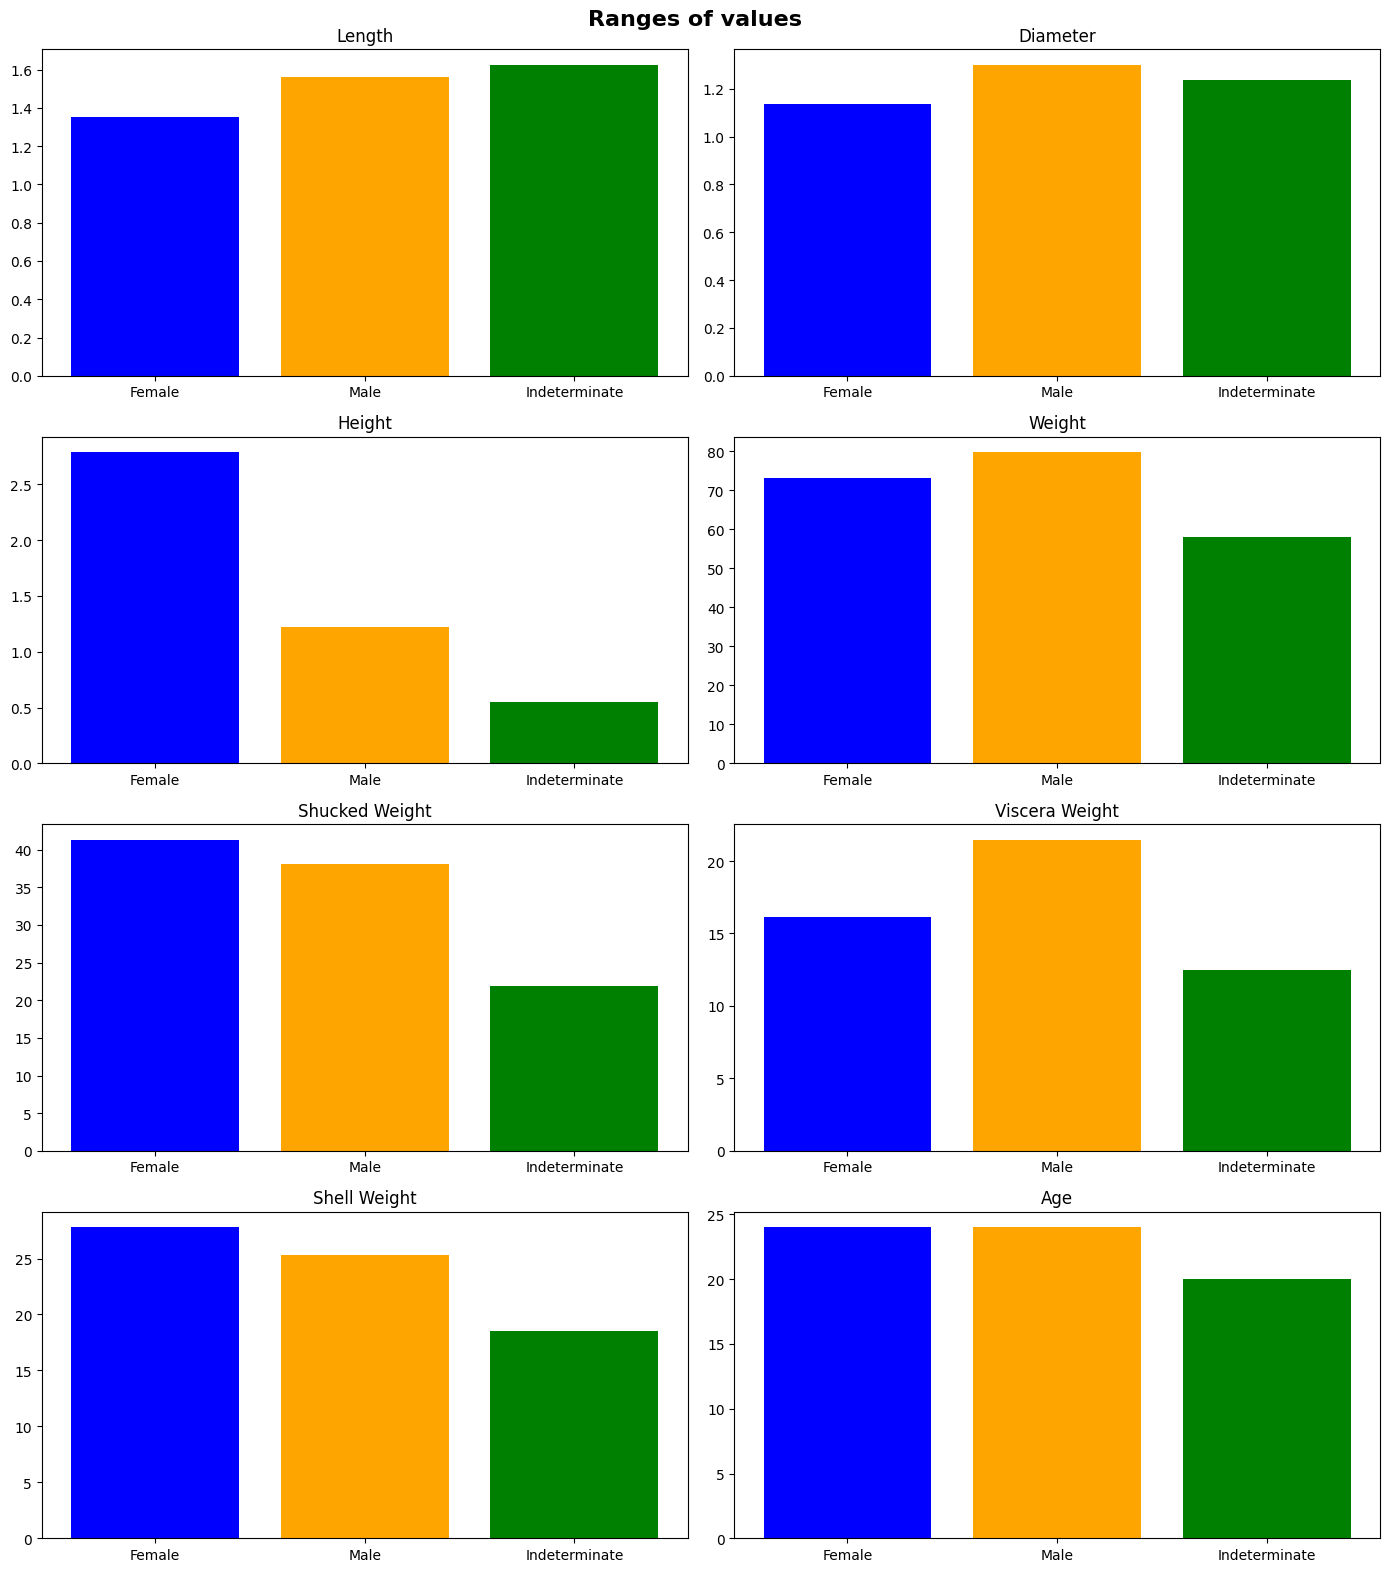

In [9]:
# Plotting ranges of values
ranges = pd.DataFrame({'Female': data[data.Sex == 'F'].describe().T['max'] - data[data.Sex == 'F'].describe().T['min'], 
                       'Male': data[data.Sex == 'M'].describe().T['max'] - data[data.Sex == 'M'].describe().T['min'], 
                       'Indeterminate': data[data.Sex == 'I'].describe().T['max'] - data[data.Sex == 'I'].describe().T['min']})


fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

for index, column_name in enumerate(ranges.index):
    row = index // 2
    column = index % 2
    ax = axs[row, column]
    ax.bar(ranges.loc[column_name].index, ranges.loc[column_name], color=['blue', 'orange', 'green'])
    ax.set_title(column_name)

fig.suptitle('Ranges of values', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

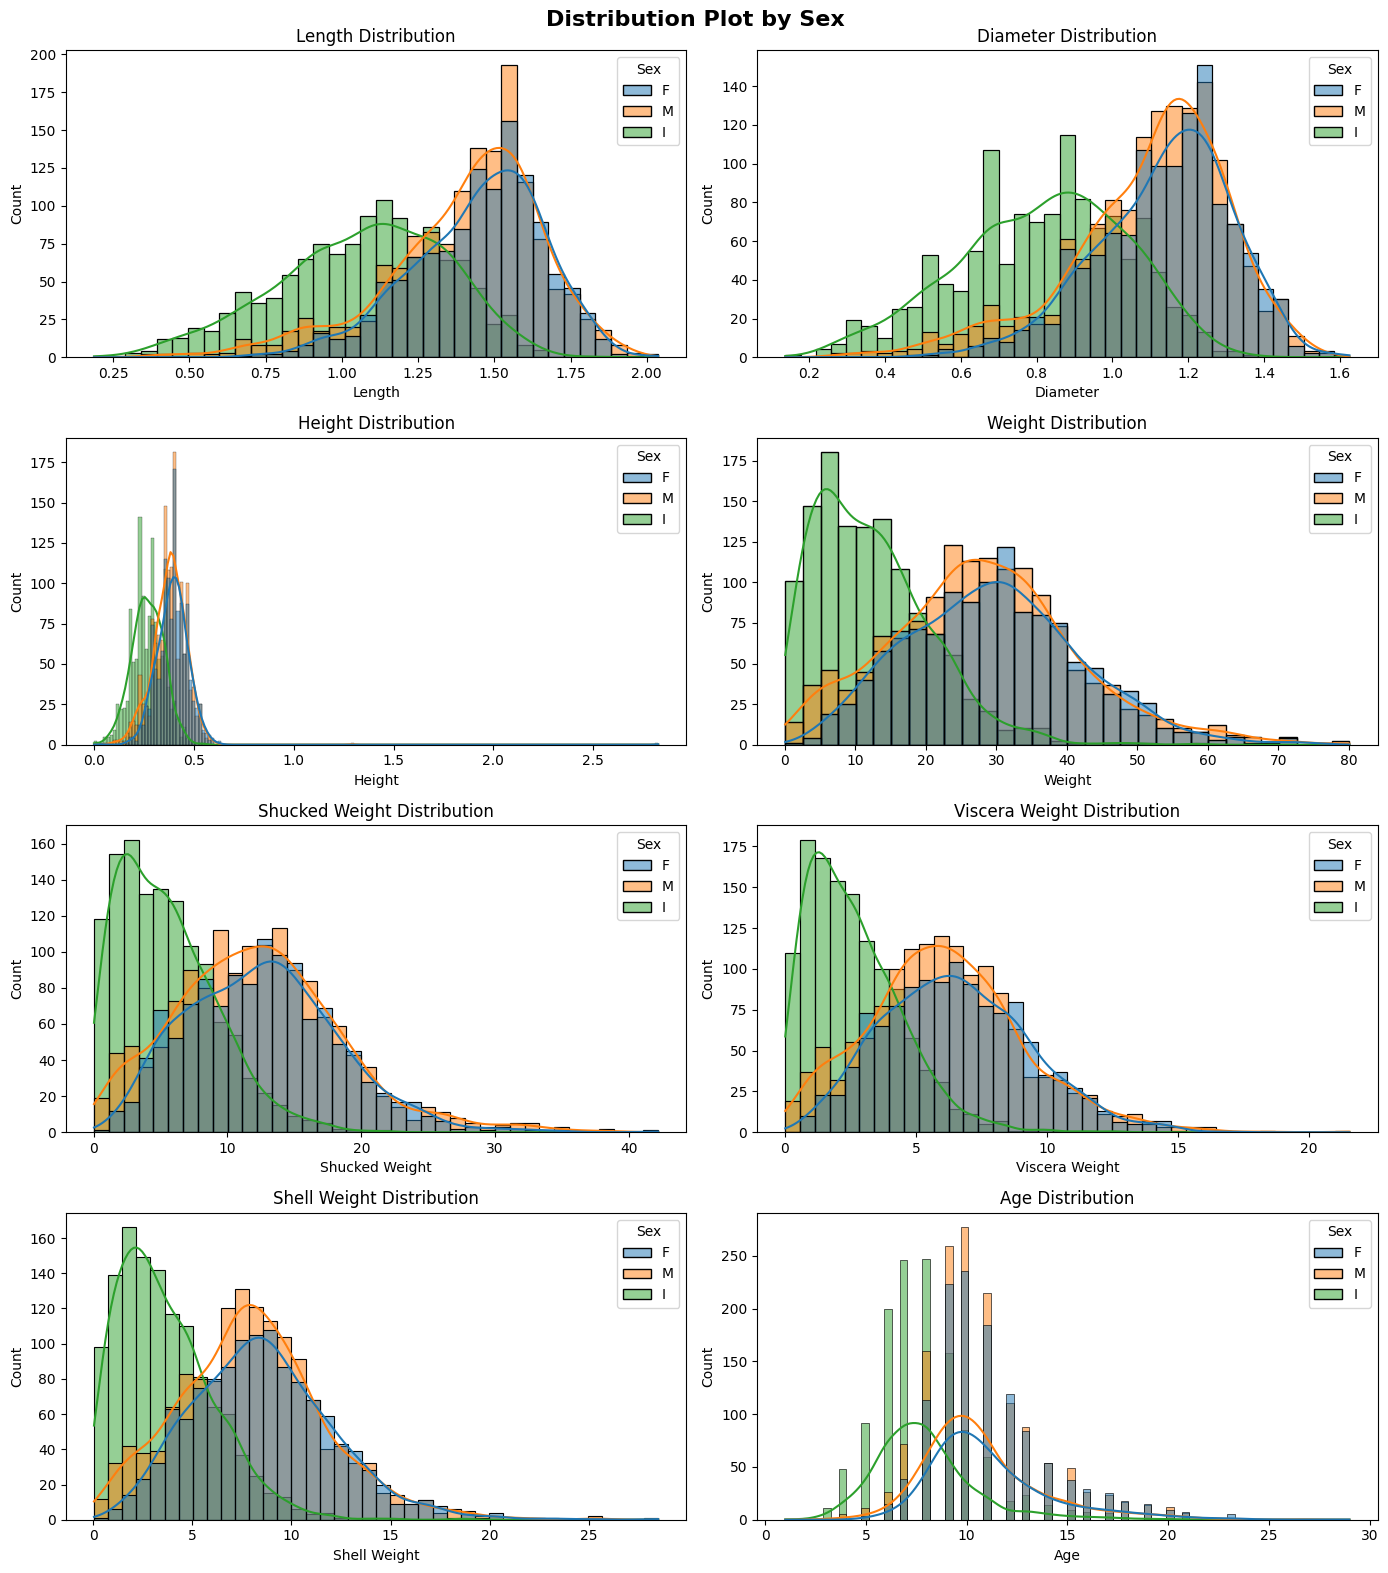

In [10]:
# Plotting distributions
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

for index, column_name in enumerate(NUMERICAL_COLS):
    row = index // 2
    column = index % 2
    ax = axs[row, column]
    sns.histplot(data=data, hue='Sex', x=column_name, kde=True, ax=ax,)
    ax.set_title(f'{column_name} Distribution')

fig.suptitle(f'Distribution Plot by Sex', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

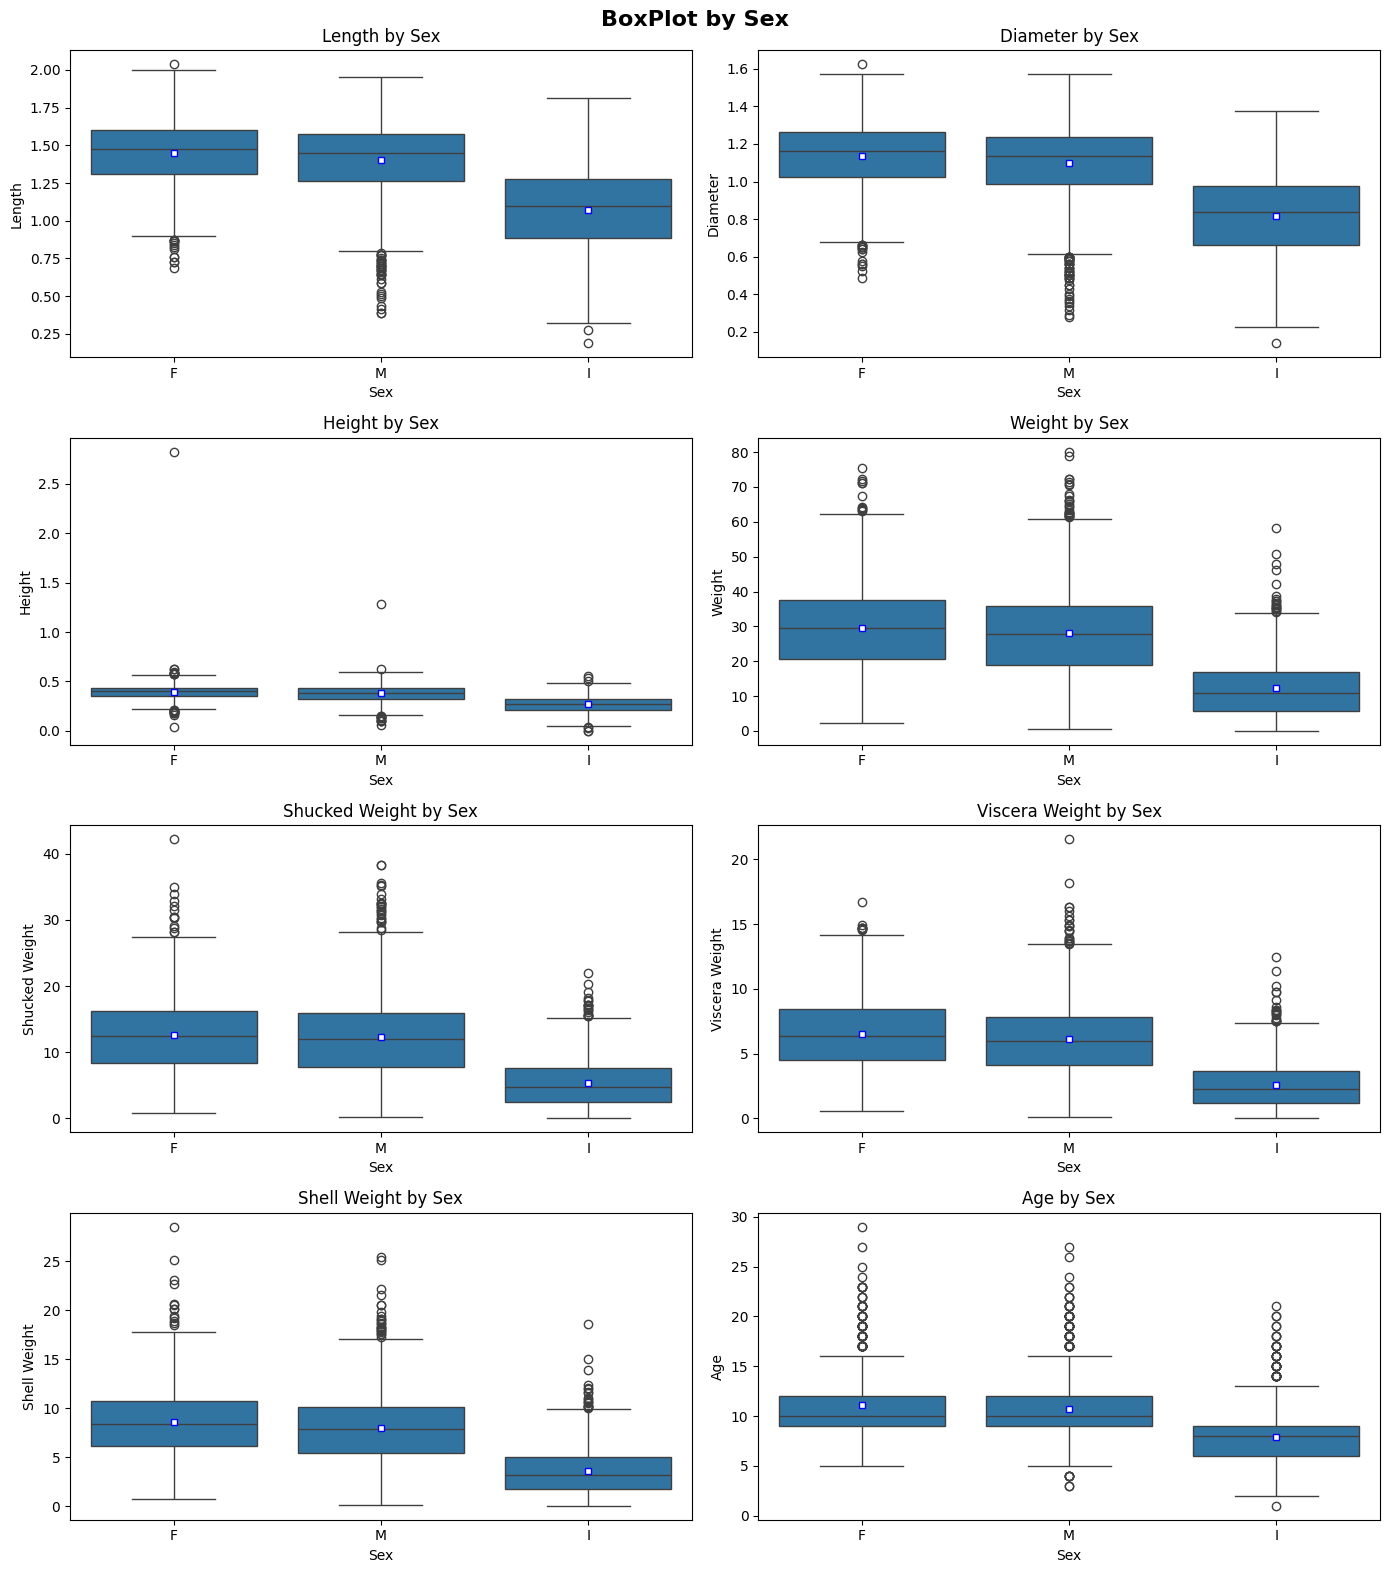

In [11]:
# Box plots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

for index, column_name in enumerate(NUMERICAL_COLS):
    row = index // 2
    column = index % 2
    ax = axs[row, column]
    sns.boxplot(data=data, x='Sex', y=column_name, showmeans=True, ax=ax, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
    ax.set_title(f'{column_name} by Sex')

fig.suptitle(f'BoxPlot by Sex', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

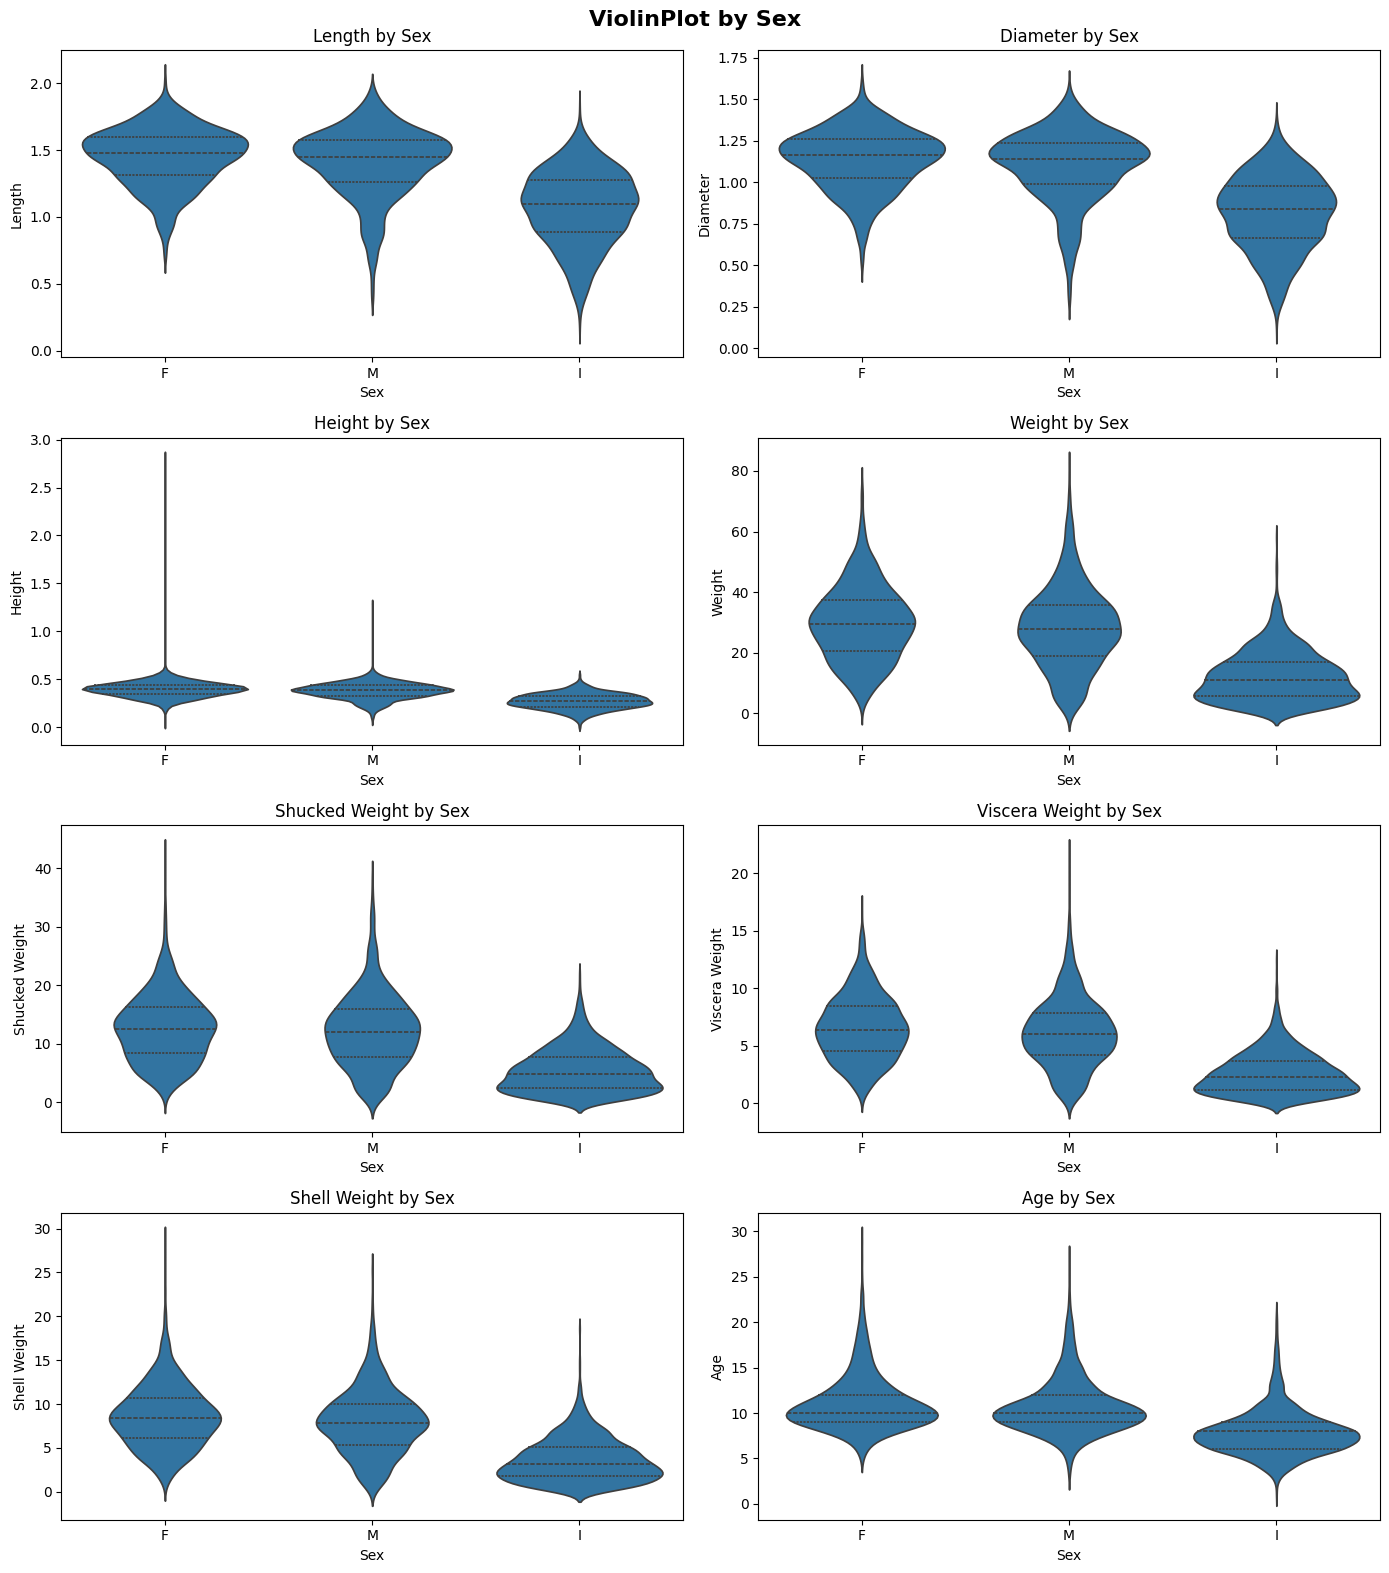

In [12]:
# Violin plots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

for index, column_name in enumerate(NUMERICAL_COLS):
    row = index // 2
    column = index % 2
    ax = axs[row, column]
    sns.violinplot(data=data, x='Sex', inner='quartile', ax=ax, y=column_name)
    ax.set_title(f'{column_name} by Sex')

fig.suptitle(f'ViolinPlot by Sex', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

## Bivariate statistics

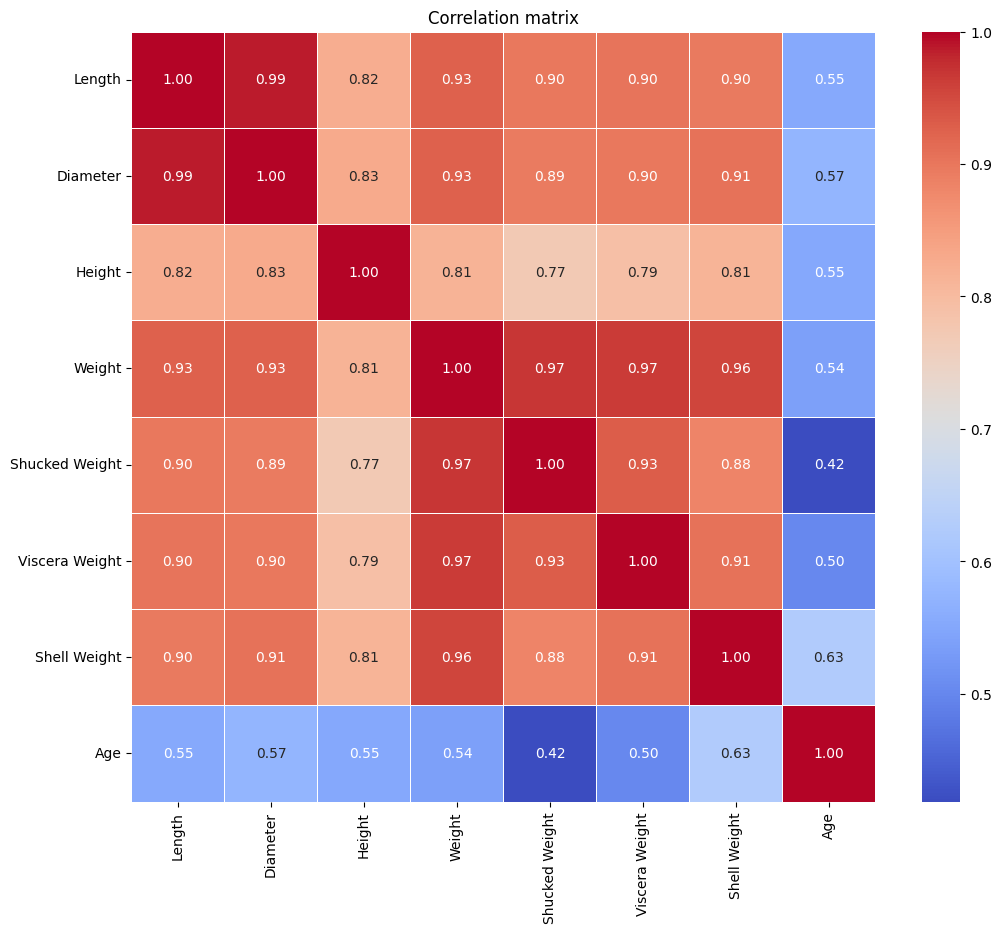

In [13]:
correlation_matrix = data[NUMERICAL_COLS].corr()


plt.figure(figsize=(12, 10))
plt.title('Correlation matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.show()

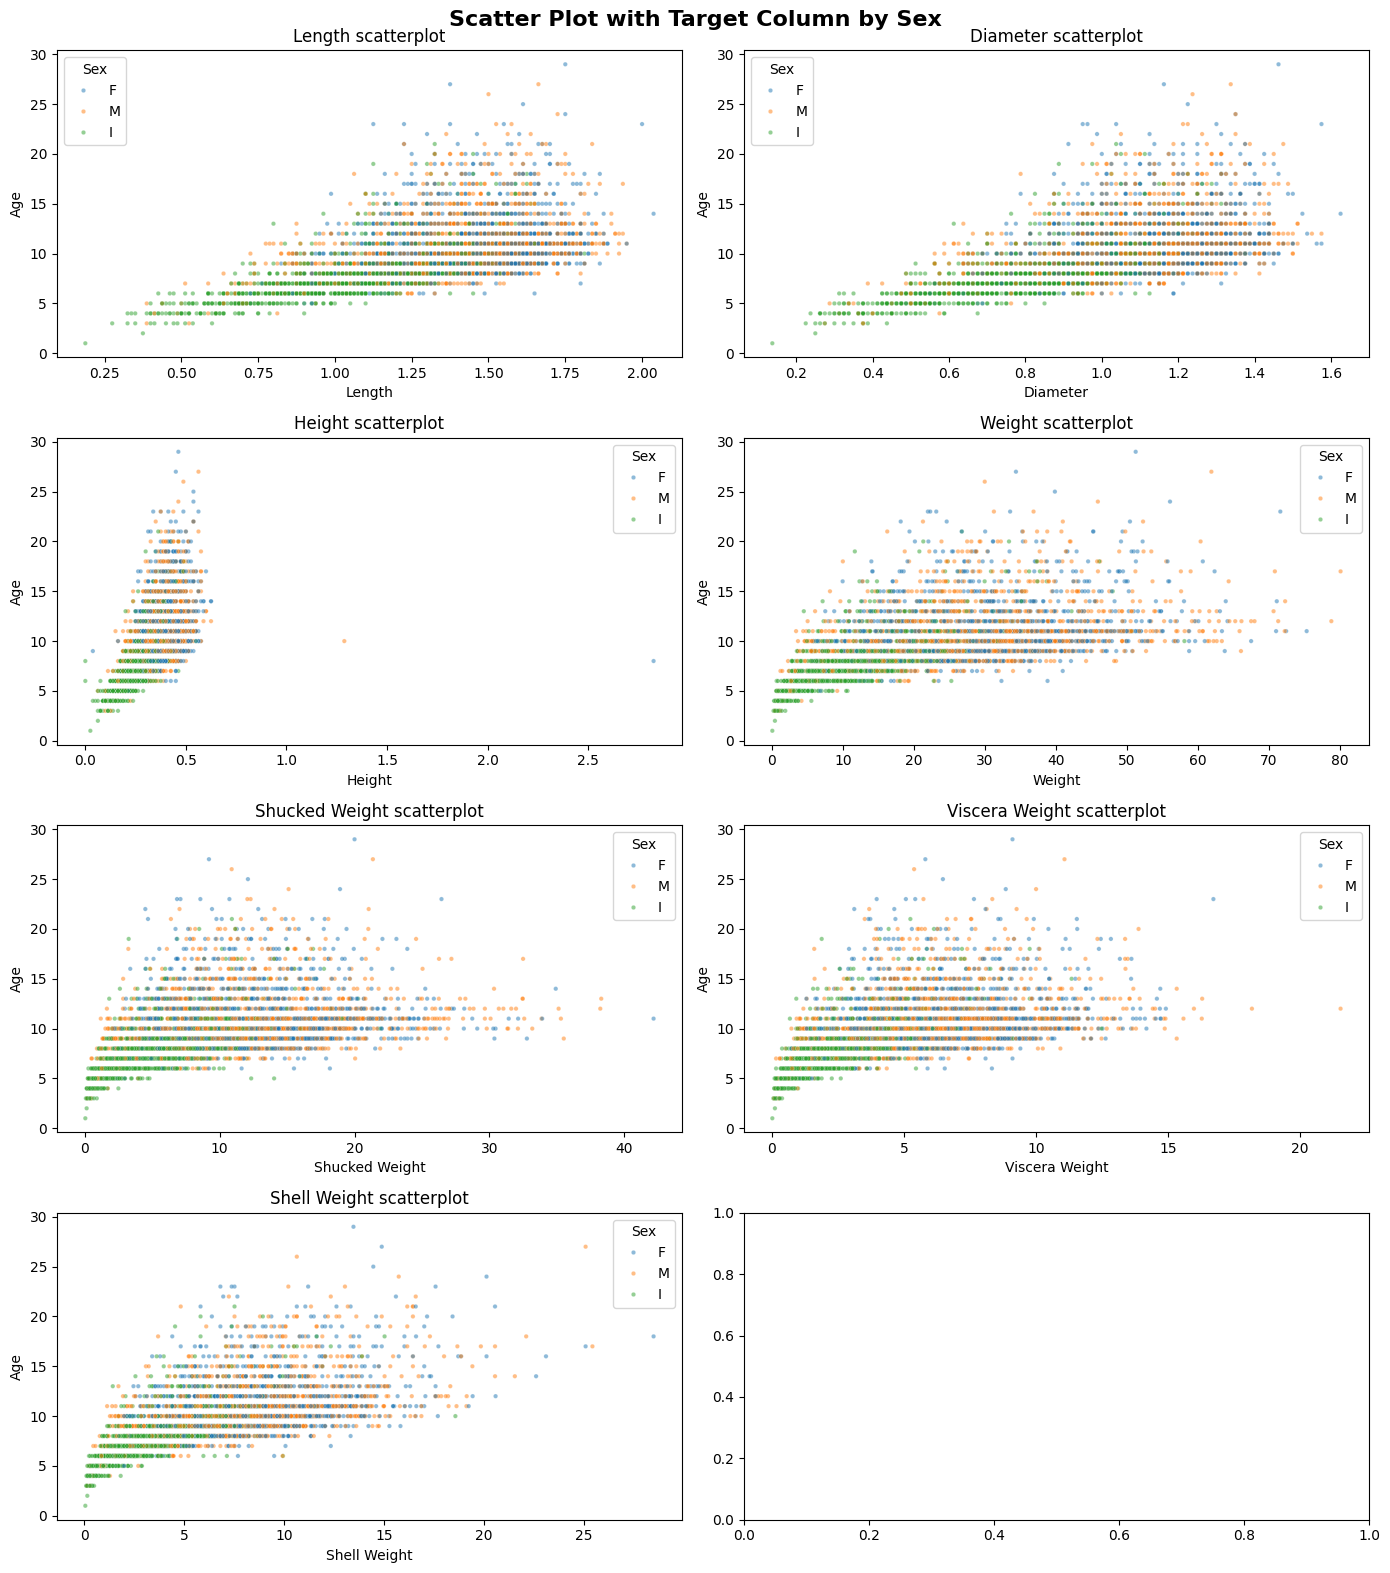

In [14]:
# Fancy scatter plots
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))

for index, column_name in enumerate(NUMERICAL_COLS[:-1]):
    row = index // 2
    column = index % 2
    ax = axs[row, column]
    sns.scatterplot(data=data, x=column_name, y='Age', hue='Sex', alpha=0.5, s=10, ax=ax)
    ax.set_title(f'{column_name} scatterplot')

fig.suptitle(f'Scatter Plot with Target Column by Sex', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# Data preparation

In [15]:
# We scale our data and one hot encode sex column
data_transformer = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), ['Sex']),
                                                   ('scaler', StandardScaler(), NUMERICAL_COLS[:-1]),
                                                   ('pass', 'passthrough', ['Age'])])

data_transformed = data_transformer.fit_transform(data)

In [16]:
# And split it
X, Y = data_transformed[::, :-1], data_transformed[::, -1]

# Model

In [17]:
# Linear Regression with L2 regularezation
estimator1 = Ridge()
grid1 = {'alpha': np.linspace(1, 5, 21)}

# Gradient boosted Random Forest
estimator2 = XGBRegressor()
grid2 = {
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': range(1, 11),
    'eta': [0.1, 0.01, 0.0001],
}

# Cross Validation for better evaluation of an algorythm
cv = KFold(5, shuffle=True)

In [18]:
# Searching for best parameters
search1 = GridSearchCV(estimator=estimator1, param_grid=grid1, cv=cv, n_jobs=-1)
search2 = GridSearchCV(estimator=estimator2, param_grid=grid2, cv=cv, n_jobs=-1)

search1.fit(X, Y)
search2.fit(X, Y)

print(f'Ridge: {search1.best_params_}')
print(f'XGBRegression: {search2.best_params_}')

Ridge: {'alpha': 1.0}
XGBRegression: {'eta': 0.01, 'max_depth': 4, 'n_estimators': 750}


# Evaluation

In [19]:
# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [21]:
# Training the first model
model1 = Ridge(**search1.best_params_)
model1.fit(X_train, Y_train)

# Getting the predictions
predictions1 = model1.predict(X_test)

In [23]:
# Useful metrics
mae1 = mean_absolute_error(Y_test, predictions1)
mse1 = mean_squared_error(Y_test, predictions1)
rmse1 = mean_squared_error(Y_test, predictions1) ** 0.5

print('Ridge')
print(f'Mean Absolute Error: {mae1}')
print(f'Mean Squared Error: {mse1}')
print(f'Root Mean Squared Error: {rmse1}')

Ridge
Mean Absolute Error: 1.6056987616388207
Mean Squared Error: 5.138529569290081
Root Mean Squared Error: 2.266832496963567


In [25]:
# Training the first model
model2 = XGBRegressor(**search2.best_params_)
model2.fit(X_train, Y_train)

# Getting the predictions
predictions2 = model2.predict(X_test)

In [27]:
# Useful metrics
mae2 = mean_absolute_error(Y_test, predictions2)
mse2 = mean_squared_error(Y_test, predictions2)
rmse2 = mean_squared_error(Y_test, predictions2) ** 0.5

print('XGBRegressor')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Squared Error: {mse2}')
print(f'Root Mean Squared Error: {rmse2}')

XGBRegressor
Mean Absolute Error: 1.527337017328772
Mean Squared Error: 4.890347746137817
Root Mean Squared Error: 2.211413065471446
